In [1]:
import pandas as pd


In [2]:

df_transactions = pd.read_csv('../data/transactions_data.csv')

In [15]:
import re
import pandas as pd
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
from data.data_functions import *
from langchain_ollama import ChatOllama
from agent.tools import crear_pdf_elementos
from langchain_core.runnables import RunnableLambda

def run_agent(input, client_id,df):
    """
    Create a simple AI Agent that generates PDF reports using the three functions from Task 2 (src/data/data_functions.py).
    The agent should generate a PDF report only if valid data is available for the specified client_id and date range.
    Using the data and visualizations from Task 2, the report should be informative and detailed.

    The agent should return a dictionary containing the start and end dates, the client_id, and whether the report was successfully created.

    Parameters
    ----------
    df : pandas DataFrame
        DataFrame  of the data to be used for the agent.
    client_id : int
        Id of the client making the request.
    input : str
        String with the client input for creating the report.


    Returns
    -------
    variables_dict : dict
        Dictionary of the variables of the query.
            {
                "start_date": "YYYY-MM-DD",
                "end_date" : "YYYY-MM-DD",
                "client_id": int,
                "create_report" : bool
            }

    """
    prompt = input
    # Step 1: Set up the Ollama model with LangChain
    model = ChatOllama(model="llama3.2:1b", temperature=0)

    # Step 2: Define a prompt template to ensure clarity
    main_prompt = PromptTemplate(
        input_variables=["client_id", "text_prompt"],
        template="""
        You are a reporting assistant for client {client_id}. Extract the required dates from the following prompt
        Text prompt: "{text_prompt}"
        In a list format, provide the extracted dates in the following format: ["YYYY-MM-DD", "YYYY-MM-DD"] without the quotes. If no dates are found, provide an empty list.

        Examples:
            - Input: "Please provide data from 2023-01-01 to 2023-12-31."
            Output: ["2023-01-01", "2023-12-31"]

            - Input: "From July 15th, 2024, to August 20th, 2024, analyze the results."
            Output: ["2024-07-15", "2024-08-20"]
        Considerations:
        - If they ask you for a specific month, you must enter the first day of the month and the last day of the month.
        """,
    )

     
    r_fail  = {
            "start_date": None,
            "end_date": None,
            "client_id": client_id,
            "create_report": False
        }
    

    # Step 3: Set up the LLMChain with the Ollama model and prompt template
    # llm_chain = LLMChain(llm=model, prompt=main_prompt)
    llm_chain = main_prompt | model
    
    # Step 4: Run the LLMChain with the provided prompt
     # Número máximo de intentos para obtener las fechas correctas
    max_attempts = 5
    attempts = 0
    found_dates = []

    # Bucle hasta obtener una respuesta válida o alcanzar el máximo de intentos
    while len(found_dates) < 2 and attempts < max_attempts:
        response = llm_chain.invoke({"client_id": client_id, "text_prompt": prompt})
        response_text = response.content

        # Extraer fechas utilizando expresiones regulares
        date_pattern = r"\b\d{4}-\d{2}-\d{2}\b"
        found_dates = re.findall(date_pattern, response_text)
        
        # Incrementar el contador de intentos
        attempts += 1
        
        # Si no se encontraron suficientes fechas, ajustar el prompt y reintentar
        if len(found_dates) < 2:
            print("No se encontraron suficientes fechas. Reintentando...")
            

    if len(found_dates) >= 2:
        start_date = found_dates[0]
        end_date = found_dates[1]
    else:
        return r_fail
    
    # if id_client is not in the data
    if client_id not in df["client_id"].unique():
        r_fail["start_date"] = start_date
        r_fail["end_date"] = end_date
        return r_fail

    ree = earnings_and_expenses(df, client_id,start_date, end_date)
    res = expenses_summary(df, client_id, start_date, end_date)
    rfs = cash_flow_summary(df, client_id, start_date, end_date)

    #nombre_pdf = f"report_{client_id}_{start_date}_{end_date}.pdf"
    nombre_pdf = "report.pdf"
    crear_pdf_elementos(rfs, res, ree, nombre_pdf)

    return {
        "start_date" : start_date,
        "end_date": end_date,
        "client_id": client_id,
        "create_report": True
    }



if __name__ == "__main__":
    ...


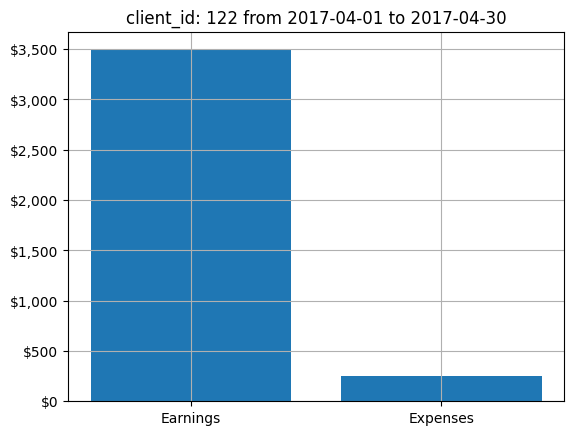

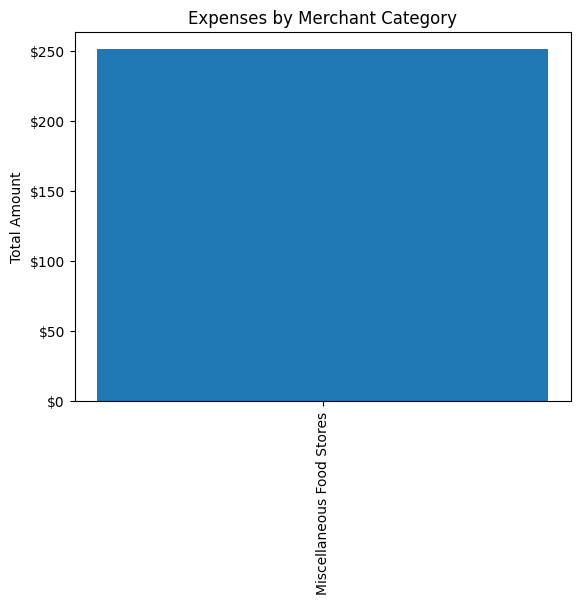

In [16]:
submitted_output = run_agent(
    input=input,
    client_id=client_id,
    df=sample_data.copy(deep=True),
)

In [4]:
def check_all_values(expected_dict, submitted_dict):
    for k in expected_dict:
        if k not in submitted_dict or expected_dict[k] != submitted_dict[k]:
            return False
    return True
report_folder = "/home/djoroya/Documents/desafio/hackathon-caixabank-data-ai-report/reports"

sample_data = df_transactions

In [5]:
input = "Create a pdf report for the fourth month of 2017"
client_id = 122
output = {
    "start_date": "2017-04-01",
    "end_date": "2017-04-30",
    "client_id": client_id,
    "create_report": True,
}
try:
    submitted_output = run_agent(
        input=input,
        client_id=client_id,
        df=sample_data.copy(deep=True),
    )
except Exception as e:
    print(e)
    submitted_output = {}

test_passed = check_all_values(output, submitted_output)
expected_length = 1 if output["create_report"] else 0
try:
    pdf_files = [
        file for file in os.listdir(report_folder) if file.endswith(".pdf")
    ]
    condition_pdf = len(pdf_files) == expected_length
except Exception as e:
    print(e)
    condition_pdf = False
assert condition_pdf and test_passed

content='To extract the required dates from the prompt, I will follow these steps:\n\n1. Identify the specific month mentioned in the prompt (in this case, "fourth month").\n2. Determine if there are any other relevant details that could help identify a specific date range.\n\nBased on the prompt, I can see that the fourth month of 2017 is April. Therefore, I will extract the dates for April:\n\n["2017-04-01", "2017-04-30"]' additional_kwargs={} response_metadata={'model': 'llama3.2:1b', 'created_at': '2024-10-27T15:40:51.329494676Z', 'message': {'role': 'assistant', 'content': ''}, 'done_reason': 'stop', 'done': True, 'total_duration': 600442407, 'load_duration': 24631461, 'prompt_eval_count': 231, 'prompt_eval_duration': 34915000, 'eval_count': 100, 'eval_duration': 497713000} id='run-dd238226-e6fc-48af-a4e1-26be214898f8-0' usage_metadata={'input_tokens': 231, 'output_tokens': 100, 'total_tokens': 331}
'AIMessage' object is not subscriptable


AssertionError: 

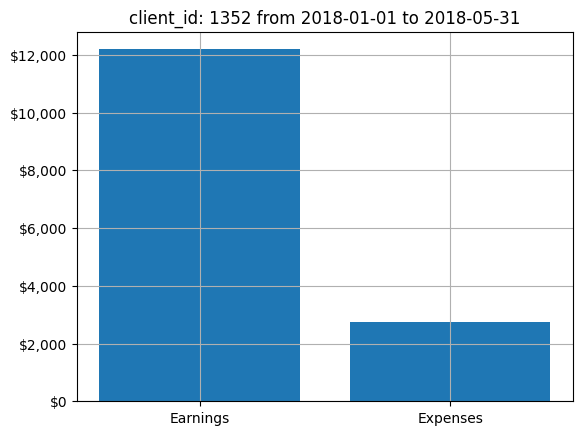

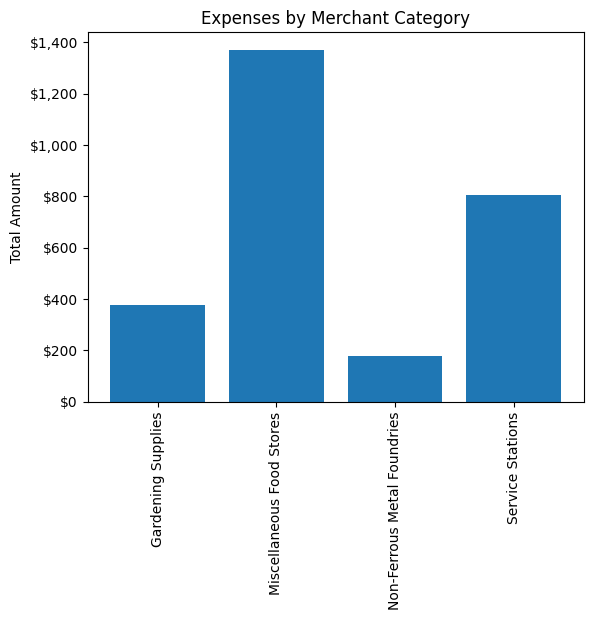

In [86]:
input = "Create a pdf report from 2018-01-01 to 2018-05-31"
client_id = 1352
output = {
    "start_date": "2018-01-01",
    "end_date": "2018-05-31",
    "client_id": client_id,
    "create_report": True,
}
try:
    submitted_output = run_agent(
        input=input,
        client_id=client_id,
        df=sample_data.copy(deep=True),
    )
except Exception as e:
    print(e)
    submitted_output = {}

test_passed = check_all_values(output, submitted_output)
expected_length = 1 if output["create_report"] else 0
try:
    pdf_files = [
        file for file in os.listdir(report_folder) if file.endswith(".pdf")
    ]
    condition_pdf = len(pdf_files) == expected_length
except Exception as e:
    print(e)
    condition_pdf = False
assert condition_pdf and test_passed

In [87]:
submitted_output

{'start_date': '2018-01-01',
 'end_date': '2018-05-31',
 'client_id': 1352,
 'create_report': True}

In [88]:
output

{'start_date': '2018-01-01',
 'end_date': '2018-05-31',
 'client_id': 1352,
 'create_report': True}

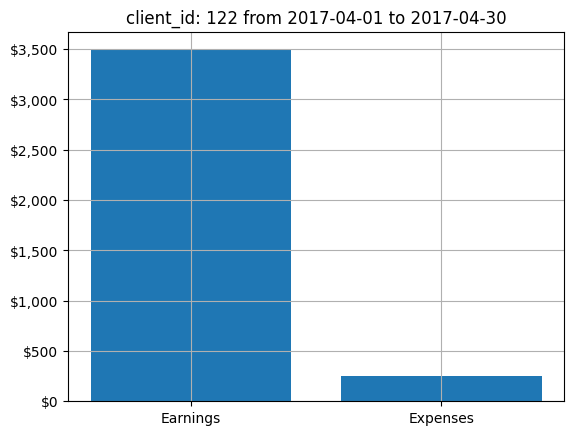

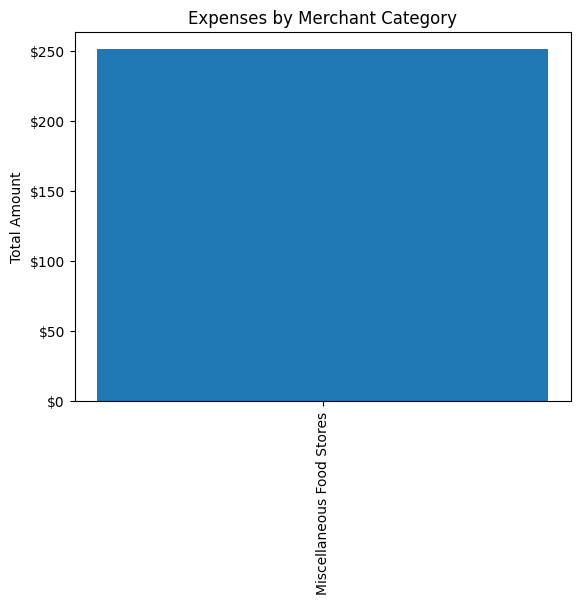

In [90]:
input = "Create a pdf report for the fourth month of 2017"
client_id = 122
output = {
    "start_date": "2017-04-01",
    "end_date": "2017-04-30",
    "client_id": client_id,
    "create_report": True,
}
try:
    submitted_output = run_agent(
        input=input,
        client_id=client_id,
        df=sample_data.copy(deep=True),
    )
except Exception as e:
    print(e)
    submitted_output = {}

test_passed = check_all_values(output, submitted_output)
expected_length = 1 if output["create_report"] else 0
try:
    pdf_files = [
        file for file in os.listdir(report_folder) if file.endswith(".pdf")
    ]
    condition_pdf = len(pdf_files) == expected_length
except Exception as e:
    print(e)
    condition_pdf = False
assert condition_pdf and test_passed

In [81]:
output

{'start_date': '2017-04-01',
 'end_date': '2017-04-30',
 'client_id': 122,
 'create_report': True}

In [82]:
submitted_output

{'start_date': '2017-04-01',
 'end_date': '2017-05-31',
 'client_id': 122,
 'create_report': True}

In [35]:
submitted_output

{'start_date': '2017-07-01',
 'end_date': '2017-07-31',
 'client_id': 122,
 'create_report': True}

In [22]:
input = "Create a pdf report from 2018-01-01 to 2018-05-31"
client_id = 7000
output = {
    "start_date": "2018-01-01",
    "end_date": "2018-05-31",
    "client_id": client_id,
    "create_report": False,
}
submitted_output = run_agent(
    input=input,
    client_id=client_id,
    df=sample_data.copy(deep=True),
)


In [23]:
submitted_output

{'start_date': None,
 'end_date': None,
 'client_id': 7000,
 'create_report': False}